In [1]:
%matplotlib inline 
import os
import math
import tqdm
import tqdm.auto
tqdm.tqdm = tqdm.auto.tqdm

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# import tensorflow_datasets as tfds

# Data Loading

In [2]:
_URL = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
zip_dir = tf.keras.utils.get_file(
    origin=_URL,
    fname="cats_dogs_dataset.zip"
)
print("Local directory: ", zip_dir)

68616192/68606236 [==============================] - 1s 0us/step
Local directory:  /root/.keras/datasets/cats_dogs_dataset.zip


In [ ]:
zip_dir_target = os.path.dirname(zip_dir)
print(zip_dir)
print(zip_dir_target)
!unzip $zip_dir -d $zip_dir_target

In [4]:
!find /Users/vuong/.keras/datasets -type d -print

find: ‘/Users/vuong/.keras/datasets’: No such file or directory


In [5]:
cats_tr = os.listdir(f'{zip_dir_target}/cats_and_dogs_filtered/train/cats')
dogs_tr = os.listdir(f'{zip_dir_target}/cats_and_dogs_filtered/train/dogs')
print('Total training cat images:', len(cats_tr))
print('Total training dog images:', len(dogs_tr))

cats_val = os.listdir(f'{zip_dir_target}/cats_and_dogs_filtered/validation/cats')
dogs_val = os.listdir(f'{zip_dir_target}/cats_and_dogs_filtered/validation/dogs')
print('Total validation cat images:', len(cats_val))
print('Total validation dog images:', len(dogs_val))
print("--")

total_tr = len(cats_tr)+len(dogs_tr)
total_val = len(cats_val)+len(dogs_val)
print("Total training images:", total_tr)
print("Total validation images:", total_val)

Total training cat images: 1000
Total training dog images: 1000
Total validation cat images: 500
Total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


# Data Preparation

Generates a tf.data.Dataset from image files in a directory.



In [6]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224

ds_train = tf.keras.preprocessing.image_dataset_from_directory(
    f'{zip_dir_target}/cats_and_dogs_filtered/train',
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=total_tr,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
)
ds_test = tf.keras.preprocessing.image_dataset_from_directory(
    f'{zip_dir_target}/cats_and_dogs_filtered/validation',
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=total_val,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [7]:
print("Class names: ", ds_train.class_names)
class_names = ds_train.class_names

Class names:  ['cats', 'dogs']


In [8]:
for images, labels in ds_train.take(1):
    print("First batch of training data: ", images.shape)
for images, labels in ds_test.take(1):
    print("First batch of testing data: ", images.shape)

First batch of training data:  (2000, 224, 224, 3)
First batch of testing data:  (1000, 224, 224, 3)


## Convert Image Data to Animal object

In [9]:
class Animal:
    def __init__(self, image, label):
        self.image = image
        self.label = label

    def normalize(self):
        self.image = self.image / 255
    
    def visualize(self, plt, class_names=[], original=False):
        if original:
            plt.imshow(self.image.astype('uint8'))
        else:
            plt.imshow(self.image)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        if not class_names:
            plt.xlabel(self.label)
        else:
            plt.xlabel(class_names[self.label])

In [10]:
def generate_dataset():
    animals_train = []
    animals_test = []

    for images, labels in ds_train.take(1):
        for i in range(total_tr):
            image = images[i].numpy()
            label = np.argmax(labels[i].numpy())
            animals_train.append(Animal(image, label))

    for images, labels in ds_test.take(1):
        for i in range(total_val):
            image = images[i].numpy()
            label = np.argmax(labels[i].numpy())
            animals_test.append(Animal(image, label))

    print("Total training animals:", len(animals_train))
    print("Total training animals:", len(animals_test))
    
    return animals_train, animals_test

animals_train, animals_test = generate_dataset()

Total training animals: 2000
Total training animals: 1000


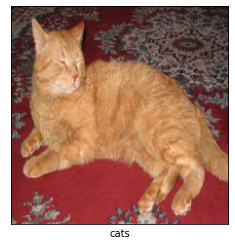

In [11]:
# Visualize the first animal in the training data
animals_train[0].visualize(plt, class_names=['cats', 'dogs'], original=True)
plt.show()

## Normalization

Rescale the tensors from values between 0 and 255 to values between 0 and 1, as neural networks prefer to deal with small input values.

In [12]:
# Normalizing
animals_train_nor, animals_test_nor = generate_dataset()

for i in range(len(animals_train_nor)):
    animals_train_nor[i].normalize()

for i in range(len(animals_test_nor)):
    animals_test_nor[i].normalize()

Total training animals: 2000
Total training animals: 1000


In [ ]:
# Print the first animal in the training data after normalization
print(animals_train_nor[0].image)

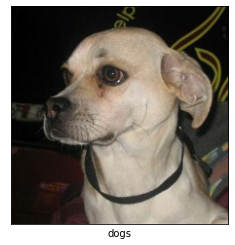

In [14]:
# Visualize the first animal in the training data
animals_train_nor[0].visualize(plt, class_names=['cats', 'dogs'])
plt.show()

## Create a Dataset in TensorFlow

We have a numpy array and we want to pass it to TensorFlow.


In [15]:
print("Total training images:", len(animals_train_nor))
print("Total validation images:", len(animals_test_nor))

Total training images: 2000
Total validation images: 1000


In [16]:
X_train, y_train = [], []
X_test, y_test = [], []

for animal in animals_train_nor:
    X_train.append(animal.image)
    y_train.append(animal.label)

for animal in animals_test_nor:
    X_test.append(animal.image)
    y_test.append(animal.label)

print("Total training images:", len(X_train))
print("Total training labels:", len(y_train))
print("Total validation images:", len(X_test))
print("Total validation labels:", len(y_test))

Total training images: 2000
Total training labels: 2000
Total validation images: 1000
Total validation labels: 1000


# Visualizing Training images

We can visualize our training images by getting a batch of images from the training dataset, and then plotting a few of them using matplotlib.

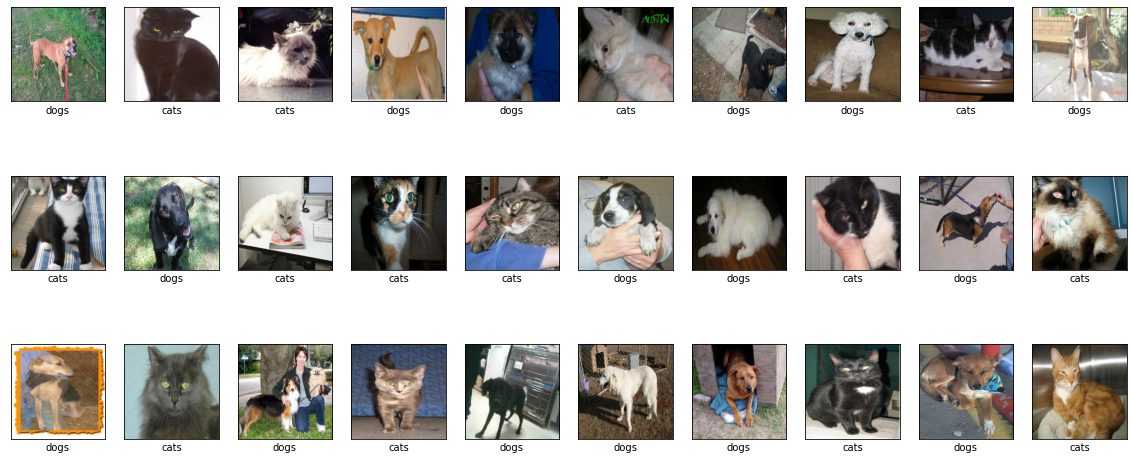

In [17]:
import random
random_list = random.sample(range(0, 2000), 30)

def show_image(image, label):
    plt.imshow(X=image)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.xlabel(label)

plt.figure(figsize=(20,15))
idx=0
for i in random_list:
    plt.subplot(5, 10, idx+1)
    image = X_train[i]  # For normalize only
    label = class_names[y_train[i]]
    show_image(image, label)
    idx+=1
plt.show()

# Baseline Model

In [18]:
def baseline_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation=tf.nn.relu, padding="same", input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3)),
        tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation=tf.nn.relu, padding="same"),
        tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation=tf.nn.relu, padding="same"),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=512, activation=tf.nn.relu),
        tf.keras.layers.Dense(units=2, activation=tf.nn.softmax)
    ])
    return model

## Train the model
It's time we train our network.

In [19]:
EPOCHS = 100
BATCH_SIZE = 100

training_dataset = tf.data.Dataset.from_tensor_slices((np.array(X_train), np.array(y_train)))
testing_dataset = tf.data.Dataset.from_tensor_slices((np.array(X_test), np.array(y_test)))

training_dataset = training_dataset.batch(batch_size=BATCH_SIZE)
testing_dataset = testing_dataset.batch(batch_size=BATCH_SIZE)

print("Total training dataset:", len(list(training_dataset)))
print("Total testing dataset:", len(list(testing_dataset)))

Total training dataset: 20
Total testing dataset: 10


In [ ]:
model = baseline_model()

model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)

history = model.fit(
    training_dataset,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=testing_dataset,
)

## Visualizing results of the training
We'll now visualize the results we get after training our network.

In [21]:
def visualize_model(history, epochs):
    acc = history.history['sparse_categorical_accuracy']
    val_acc = history.history['val_sparse_categorical_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

visualize_model(history, EPOCHS)

# Fine Tuning

## Data augmentation

Data augmentation takes the approach of generating additional training images by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data, prevent overfitting and generalize better.



In the cell below, use Keras to create a transformation that applies a random horizontal/vertical flip, a random 90 degree rotation, a random zoom of up to 150%, and a range for randomly picking a brightness shift value from.

In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

EPOCHS = 100
BATCH_SIZE = 100

In [23]:
# Re-generate data
animals_train, animals_test = generate_dataset()

X_train, y_train = [], []
X_test, y_test = [], []

for animal in animals_train:
    X_train.append(animal.image)
    y_train.append(animal.label)

for animal in animals_test:
    X_test.append(animal.image)
    y_test.append(animal.label)

print("Total training images:", len(X_train))
print("Total training labels:", len(y_train))
print("Total validation images:", len(X_test))
print("Total validation labels:", len(y_test))

Total training animals: 2000
Total training animals: 1000
Total training images: 2000
Total training labels: 2000
Total validation images: 1000
Total validation labels: 1000


Takes data and label arrays, then generates batches of augmented data.

In [24]:
def get_data_from_numpy():
    training_data_generator = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode="nearest"
    )
    train_data_gen = training_data_generator.flow(x=np.array(X_train), 
                                                  y=np.array(y_train), 
                                                  batch_size=BATCH_SIZE, 
                                                  shuffle=True)
    
    val_data_generator = ImageDataGenerator(rescale=1./255)
    val_data_gen = val_data_generator.flow(x=np.array(X_test), 
                                           y=np.array(y_test))
    
    return train_data_gen, val_data_gen

Takes the path to a directory and generates batches of augmented data.

In [38]:
def get_data_from_directory():
    training_data_generator = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode="nearest"
    )
    train_data_gen = training_data_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                         directory=f'{zip_dir_target}/cats_and_dogs_filtered/train',
                                                         shuffle=True,
                                                         target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                                         class_mode='binary')

    val_data_generator = ImageDataGenerator(rescale=1./255)
    val_data_gen = val_data_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory=f'{zip_dir_target}/cats_and_dogs_filtered/validation',
                                                     target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                                     class_mode='binary')
    return train_data_gen, val_data_gen

Let's visualize how a single image would look like different times, when we pass these augmentations randomly to our dataset.

In [26]:
def plot_images_from_image_generators(img_generator):
    fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20,20))
    for i in range(5):
        img, label = img_generator.next()
        ax[i].imshow(img[0])
        ax[i].axis("off")

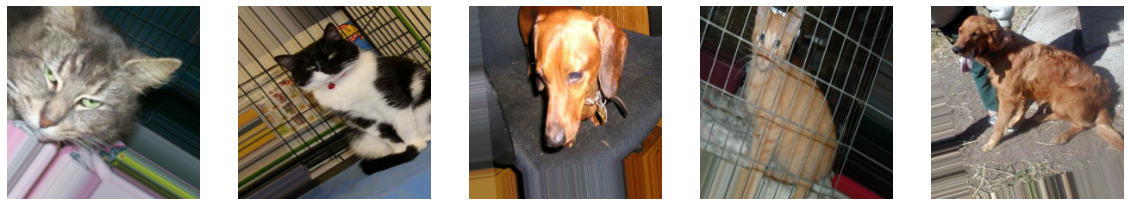

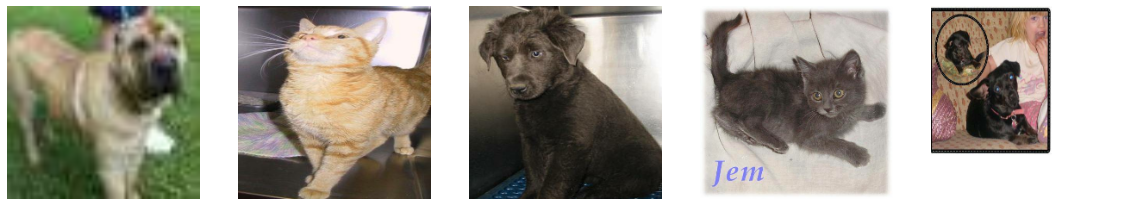

In [27]:
train_data_gen, val_data_gen = get_data_from_numpy()

plot_images_from_image_generators(train_data_gen)
plot_images_from_image_generators(val_data_gen)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


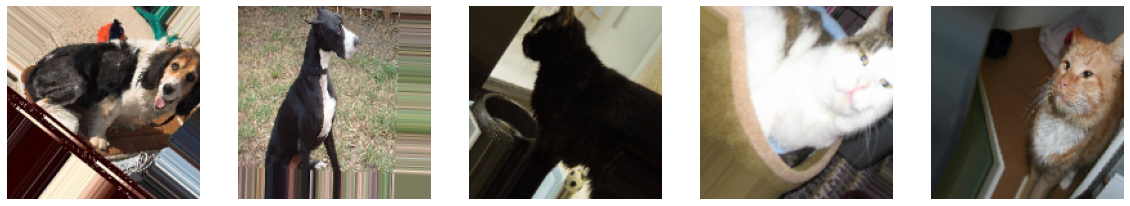

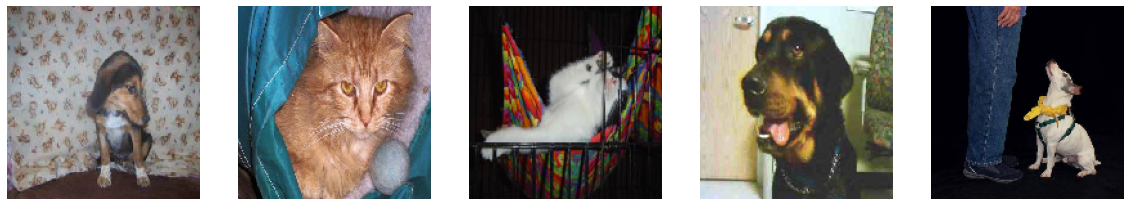

In [28]:
train_data_gen, val_data_gen = get_data_from_directory()

plot_images_from_image_generators(train_data_gen)
plot_images_from_image_generators(val_data_gen)

### Model with Data Augmentation

In [29]:
def get_model_with_data_augmentation():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation=tf.nn.relu, padding="valid", input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)),
        tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation=tf.nn.relu, padding="valid"),
        tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation=tf.nn.relu, padding="valid"),
        tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation=tf.nn.relu, padding="valid"),
        tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=512, activation=tf.nn.relu),
        tf.keras.layers.Dense(units=2, activation=tf.nn.softmax)
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.sparse_categorical_crossentropy,
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
    )
    return model

In [30]:
!pip install tensorflow_addons

     |████████████████████████████████| 1.1 MB 8.0 MB/s 


In [ ]:
# Callbacks
from tqdm.keras import TqdmCallback
import tensorflow_addons as tfa

tqdm_callback = tfa.callbacks.TQDMProgressBar()
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="best_model.hdf5",
    monitor="val_sparse_categorical_accuracy",
    verbose=1, 
    save_best_only=True,
    mode="max",
    save_freq="epoch"
)

# Model
model_1 = get_model_with_data_augmentation()
model_1.summary()

# Training
train_data_gen, val_data_gen = get_data_from_numpy()
history_1 = model_1.fit(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_tr / float(BATCH_SIZE))),
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE))),
    callbacks=[cp_callback, tqdm_callback],
    verbose=0  # replace by tqdm_callback
)

### Visualizing the training model

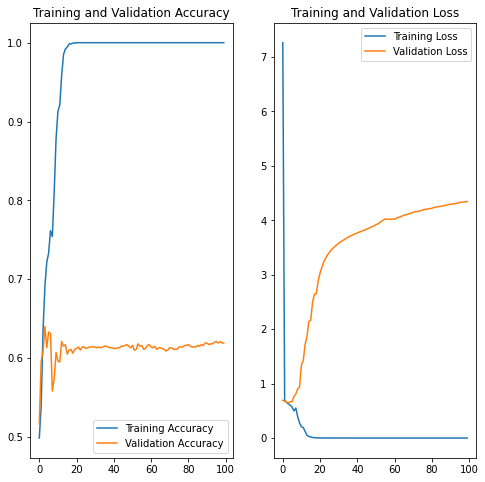

In [32]:
visualize_model(history, EPOCHS)

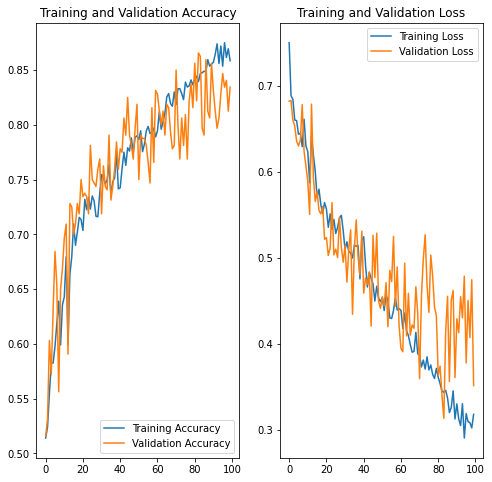

In [33]:
visualize_model(history_1, EPOCHS)

# Image Recognition: Dogs vs Cats!

In [40]:
def image_url_to_numpy_array_skimage(url,format=None):
    from skimage import io
    from PIL import Image
    image = io.imread(url)
    image = np.asarray(image, dtype="uint8")
    if format=='BGR' :
        ## return BGR format array
        img_arr = image[...,[2,1,0]]
    else:
        img_arr = image
    return np.array(Image.fromarray(img_arr).resize((IMAGE_HEIGHT, IMAGE_WIDTH), Image.ANTIALIAS))/255

Clone the model.
The model weights (that are considered the best) are loaded into the model.

In [35]:
best_model = tf.keras.models.clone_model(model_1, input_tensors=None, clone_function=None)
best_model.load_weights("best_model.hdf5")

Predict the list of animals.

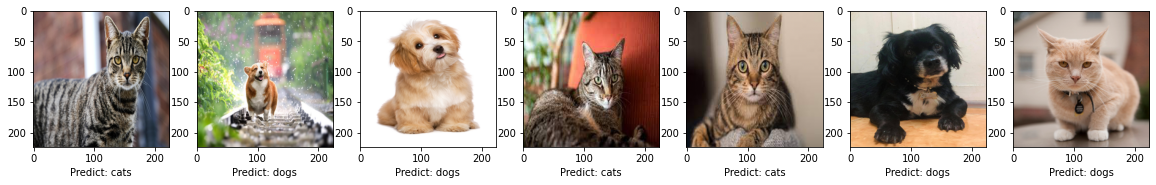

In [99]:
images_dir = ["data/sample_00.jpg", "data/sample_01.jpg", "data/sample_02.jpg", 
              "data/sample_03.jpg", "data/sample_04.jpg", "data/sample_05.jpg",
              "data/sample_06.jpg"]
fig, ax = plt.subplots(nrows=1, ncols=len(images_dir), figsize=(20,20))
for i in range(len(images_dir)):
    sample = image_url_to_numpy_array_skimage(images_dir[i])
    ax[i].imshow(sample)
    ax[i].set_xlabel(f'Predict: {class_names[np.argmax(best_model.predict(np.array([sample])))]}')

# Transfer Learning

## Import

In [53]:
!pip install tensorflow_hub

In [54]:
from __future__ import absolute_import, division, print_function
import tensorflow_hub as hub

## Load Pretrained MobileNet model

In [55]:
def get_model_mobile_net():
    MOBILE_NET_URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"
    model = tf.keras.Sequential([
        hub.KerasLayer(MOBILE_NET_URL, input_shape=(224, 224, 3))
    ])
    return model

model_mobile_net = get_model_mobile_net()

Download the ImageNet Labels

In [56]:
def load_labels_from_url(url):
    import urllib
    class_names = []
    file = urllib.request.urlopen(IMAGE_NET_LABELS_URL)
    for line in file:
        decoded_line = line.decode("utf-8").strip()
        class_names.append(decoded_line)
    return class_names

IMAGE_NET_LABELS_URL = "https://raw.githubusercontent.com/leferrad/tensorflow-mobilenet/master/imagenet/labels.txt"
imagenet_class_names = load_labels_from_url(IMAGE_NET_LABELS_URL)

print("Total labels: ", len(imagenet_class_names))
print("First 5 labels: ", imagenet_class_names[:5])

Total labels:  1001
First 5 labels:  ['background', 'tench, Tinca tinca', 'goldfish, Carassius auratus', 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', 'tiger shark, Galeocerdo cuvieri']


## Predict images from training dataset

In [90]:
X_train, y_train = [], []
X_test, y_test = [], []

for animal in animals_train_nor:
    X_train.append(animal.image)
    y_train.append(animal.label)

for animal in animals_test_nor:
    X_test.append(animal.image)
    y_test.append(animal.label)

print("Total training images:", len(X_train))
print("Total training labels:", len(y_train))
print("Total validation images:", len(X_test))
print("Total validation labels:", len(y_test))

Total training images: 2000
Total training labels: 2000
Total validation images: 1000
Total validation labels: 1000


In [91]:
plt.figure(figsize=(20,15))
idx=0
for i in random_list:
    plt.subplot(5, 10, idx+1)
    image = X_train[i]  # For normalize only
    preds = model_mobile_net.predict(np.array([image]))
    label = imagenet_class_names[np.argmax(preds)]
    show_image(image, label)
    idx+=1
plt.show()

# Custom MobileNet Pretrained Model

## Freeze the MobileNet Model Layer

In addition to complete models, TensorFlow Hub also distributes models without the last classification layer, which will be taken from `image feature vector`. 

In [92]:
def get_custom_model_mobile_net():
    MOBILE_NET_URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
    mobile_net_keras_layer = hub.KerasLayer(MOBILE_NET_URL, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
    mobile_net_keras_layer.trainable = False

    model = tf.keras.Sequential([
        mobile_net_keras_layer,
        tf.keras.layers.Dense(units=2, activation=tf.nn.softmax)
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.sparse_categorical_crossentropy,
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
    )

    return model

## Prepare training and validation dataset

We don't need data augmentation to train the custom model.

In [93]:
EPOCHS = 100
BATCH_SIZE = 100

training_dataset = tf.data.Dataset.from_tensor_slices((np.array(X_train), np.array(y_train)))
testing_dataset = tf.data.Dataset.from_tensor_slices((np.array(X_test), np.array(y_test)))

training_dataset = training_dataset.batch(batch_size=BATCH_SIZE)
testing_dataset = testing_dataset.batch(batch_size=BATCH_SIZE)

print("Total training dataset:", len(list(training_dataset)))
print("Total testing dataset:", len(list(testing_dataset)))

Total training dataset: 20
Total testing dataset: 10


## Train the custom MobileNet model

In [94]:
# Callbacks
from tqdm.keras import TqdmCallback
import tensorflow_addons as tfa

tqdm_callback = tfa.callbacks.TQDMProgressBar()
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="best_model.hdf5",
    monitor="val_sparse_categorical_accuracy",
    verbose=1, 
    save_best_only=True,
    mode="max",
    save_freq="epoch"
)

# Model
custom_model_mobile_net = get_custom_model_mobile_net()
custom_model_mobile_net.summary()

# Training
EPOCHS = 5
history_custom_model_mobile_net = custom_model_mobile_net.fit(
    training_dataset,
    steps_per_epoch=int(np.ceil(total_tr / float(BATCH_SIZE))),
    epochs=EPOCHS,
    validation_data=testing_dataset,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE))),
    callbacks=[cp_callback, tqdm_callback],
    verbose=0  # replace by tqdm_callback
)

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_12 (KerasLayer)  (None, 1280)             2257984   
                                                                 
 dense_19 (Dense)            (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


Training:   0%|           0/5 ETA: ?s,  ?epochs/s

Epoch 1/5


0/20           ETA: ?s - 


Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.98300, saving model to best_model.hdf5
Epoch 2/5


0/20           ETA: ?s - 


Epoch 00002: val_sparse_categorical_accuracy improved from 0.98300 to 0.98600, saving model to best_model.hdf5
Epoch 3/5


0/20           ETA: ?s - 


Epoch 00003: val_sparse_categorical_accuracy improved from 0.98600 to 0.98800, saving model to best_model.hdf5
Epoch 4/5


0/20           ETA: ?s - 


Epoch 00004: val_sparse_categorical_accuracy improved from 0.98800 to 0.99000, saving model to best_model.hdf5
Epoch 5/5


0/20           ETA: ?s - 


Epoch 00005: val_sparse_categorical_accuracy did not improve from 0.99000


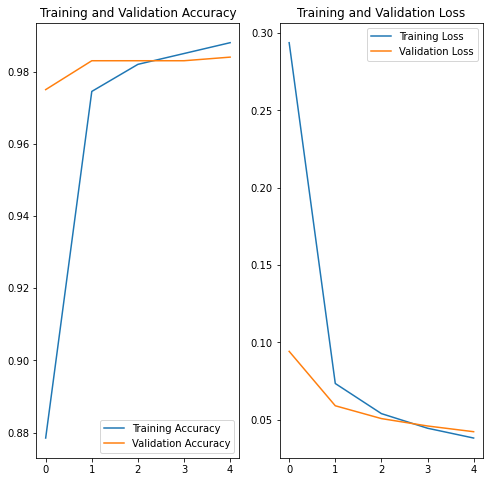

In [89]:
visualize_model(history_custom_model_mobile_net, EPOCHS)

## Predict sample images

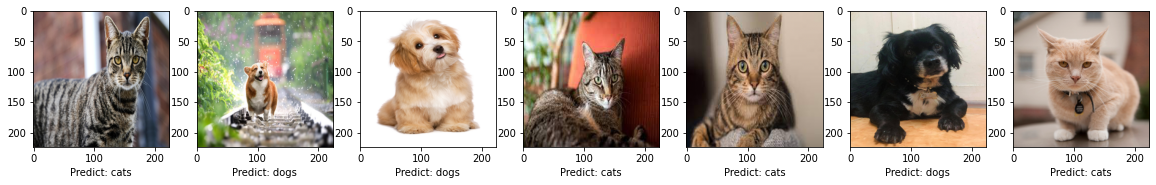

In [98]:
images_dir = ["data/sample_00.jpg", "data/sample_01.jpg", "data/sample_02.jpg", 
              "data/sample_03.jpg", "data/sample_04.jpg", "data/sample_05.jpg",
              "data/sample_06.jpg"]
fig, ax = plt.subplots(nrows=1, ncols=len(images_dir), figsize=(20,20))
for i in range(len(images_dir)):
    sample = image_url_to_numpy_array_skimage(images_dir[i])
    ax[i].imshow(sample)
    ax[i].set_xlabel(f'Predict: {class_names[np.argmax(custom_model_mobile_net.predict(np.array([sample])))]}')